In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time
import tensorflow as tf

# train
import torch
from torch import nn
from torch.nn import functional as F

# load data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 1. Data
* you can use any data normalisation method
* one example of the data normalisation is whitenning as given by:

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

* load the MNIST dataset
* use the original `training` dataset for `testing` your model
* use the original `testing` dataset for `training` your model

In [3]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)


Extracting ./MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\MNIST\raw


Extracting ./MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw


Extracting ./MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\MNIST\raw


Extracting ./MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw
Processing...


C:\Users\KSY\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


* Note that the number of your `training` data must be 10,000
* Note that the number of your `testing` data must be 60,000


In [6]:
print("the number of your training data (must be 10,000) =", data_train.__len__())
print("the number of your testing data (must be 60,000) =", data_test.__len__())


the number of your training data (must be 10,000) = 10000
the number of your testing data (must be 60,000) = 60000


## Model
* design a neural network architecture with three layers (input layer, one hidden layer and output layer)
* the input dimension of the input layer should be 784 (28 * 28)
* the output dimension of the output layer should be 10 (class of digits)
* all the layers should be `fully connected layers`
* use any type of activation functions

In [7]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out

## Optimization
* use any stochastic gradient descent algorithm for the optimization
* use any size of the mini-batch
* use any optimization algorithm (for example, Momentum, AdaGrad, RMSProp, Adam)
* use any regularization algorithm (for example, Dropout, Weight Decay)
* use any annealing scheme for the learning rate (for example, constant, decay, staircase)

In [8]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [10]:
batch_size = 32
lr=0.5
n_epochs = 20

no_cuda = True
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=True)

classifier = classification().to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr)

criterion = nn.NLLLoss()

accuracy_stats = {
    'train': [],
    "test": []
}
loss_stats = {
    'train': [],
    "test": []
}

for epoch in range(n_epochs):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    classifier.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = classifier(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = accuracy(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    with torch.no_grad():
        test_epoch_loss = 0
        test_epoch_acc = 0
        
        classifier.eval()
        
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        
            y_test_pred = classifier(X_test_batch)
            
            test_loss = criterion(y_test_pred, y_test_batch)
            test_acc = accuracy(y_test_pred, y_test_batch)
            
            test_epoch_loss += test_loss.item()
            test_epoch_acc += test_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['test'].append(test_epoch_acc/len(test_loader))
         
print('done')

done


In [74]:
print(loss_stats['test'])

[0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281, 0.0648531833662281,

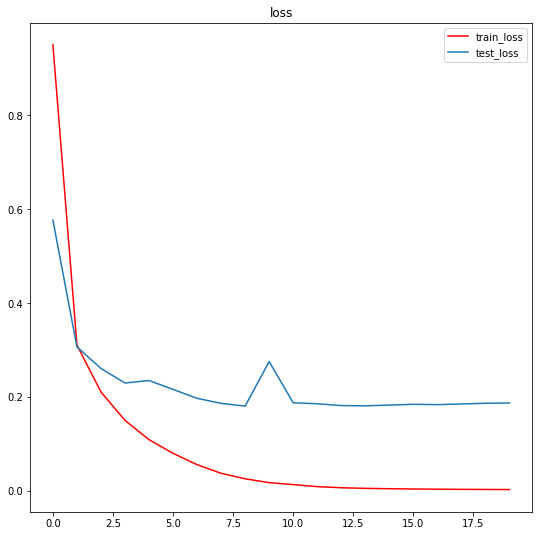

In [11]:
plt.figure(1,figsize=(9,9))
plt.plot(np.array(range(n_epochs)), loss_stats['train'], c='r', label='train_loss')
plt.plot(np.array(range(n_epochs)), loss_stats['test'], label='test_loss')
plt.legend()
plt.title('loss')
plt.show()

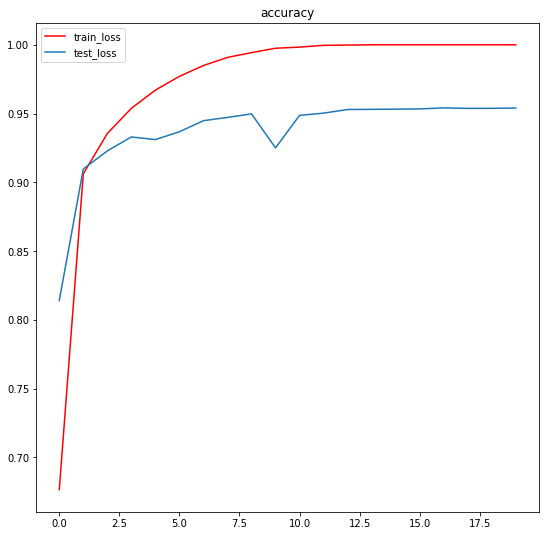

In [12]:
plt.figure(1,figsize=(9,9))
plt.plot(np.array(range(n_epochs)), accuracy_stats['train'], c='r', label='train_loss')
plt.plot(np.array(range(n_epochs)), accuracy_stats['test'], label='test_loss')
plt.legend()
plt.title('accuracy')
plt.show()

In [86]:
final_train_loss = []
final_test_loss = []
final_train_acc = []
final_test_acc = []

In [108]:
final_train_loss.append(loss_stats['train'][-1])
final_test_loss.append(loss_stats['test'][-1])
final_train_acc.append(accuracy_stats['train'][-1])
final_test_acc.append(accuracy_stats['test'][-1])

In [104]:
print('%.6f' % final_train_loss[1])

0.001297


In [115]:
print('mini-batch size = 32 | training accuracy = %.6f'% final_train_acc[0], '| testing accuracy = %.6f'% final_test_acc[0])
print('mini-batch size = 64 | training accuracy = %.6f'% final_train_acc[1], '| testing accuracy = %.6f'% final_test_acc[1])
print('mini-batch size = 128 | training accuracy = %.6f'% final_train_acc[2], '| testing accuracy = %.6f'% final_test_acc[2])

mini-batch size = 32 | training accuracy = 1.000000 | testing accuracy = 0.985124
mini-batch size = 64 | training accuracy = 1.000000 | testing accuracy = 0.982882
mini-batch size = 128 | training accuracy = 0.999650 | testing accuracy = 0.982298


## 1. Plot the training and testing losses over epochs [2pt]

## 2. Plot the training and testing accuracies over epochs [2pt]

## 3. Print the final training and testing losses at convergence [2pt]

## 4. Print the final training and testing accuracies at convergence [20pt]